# Rescaled Range Analysis

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from scipy import stats
# sns.set_theme()
import backtrader as bt
import backtrader.feeds as btfeed
%matplotlib inline

In [4]:
# read spot data
df_spot = pd.read_pickle('overall.pkl')
df_perp = pd.read_pickle('perp_overall.pkl')
df_spot.ticker.unique()

array(['BINANCE_SPOT_BTC_USDT', 'BINANCE_SPOT_ETH_USDT',
       'BINANCE_SPOT_BNB_USDT', 'BINANCE_SPOT_ADA_USDT',
       'BINANCE_SPOT_XRP_USDT', 'BINANCE_SPOT_MATIC_USDT',
       'BINANCE_SPOT_SOL_USDT', 'BINANCE_SPOT_UNI_USDT',
       'BINANCE_SPOT_AVAX_USDT'], dtype=object)

In [6]:
def df_select(path: str, ticker: str, start_date: str, data_point_num: int) -> pd.DataFrame:
    data = pd.read_pickle(path)
    data = data.loc[data['ticker'] == ticker]
    data = data.reset_index(drop=True)
    data['ret'] = data['price_close'].pct_change()
    data.iloc[:, :4] = data.iloc[:, :4].apply(pd.to_datetime, utc=True, errors='coerce')
    data = data.loc[data['time_period_start'] >= start_date]
    if data_point_num is not None:
        data = data.head(data_point_num)
    return data[['time_period_start', 'price_close', 'ret']]

#### testing cerebro for btc-usdt

In [24]:
test_data = df_select('overall.pkl', ticker='BINANCE_SPOT_BTC_USDT', start_date='2020-11-01', data_point_num=672)
test_data = test_data[['time_period_start', 'ret']] 
test_data.set_index('time_period_start', inplace=True)

In [25]:
test_data.head()

,ret
time_period_start,
2020-11-01 00:00:00+00:00,-0.004717
2020-11-01 01:00:00+00:00,0.002473
2020-11-01 02:00:00+00:00,-0.003199
2020-11-01 03:00:00+00:00,-0.001886
2020-11-01 04:00:00+00:00,-0.000932


In [26]:
# https://www.backtrader.com/docu/pandas-datafeed/pandas-datafeed/
# 
class PandasData(bt.feeds.PandasData):
    lines = ('time_period_start','ret')
    params = (
        ('time_period_start', None),
        # ('price_close', 'price_close'),
        ('ret', 'ret'),
    )
    
class St(bt.Strategy):
    def __init__(self):
        self.sma = bt.indicators.SimpleMovingAverage(self.data)

posx and posy should be finite values
posx and posy should be finite values


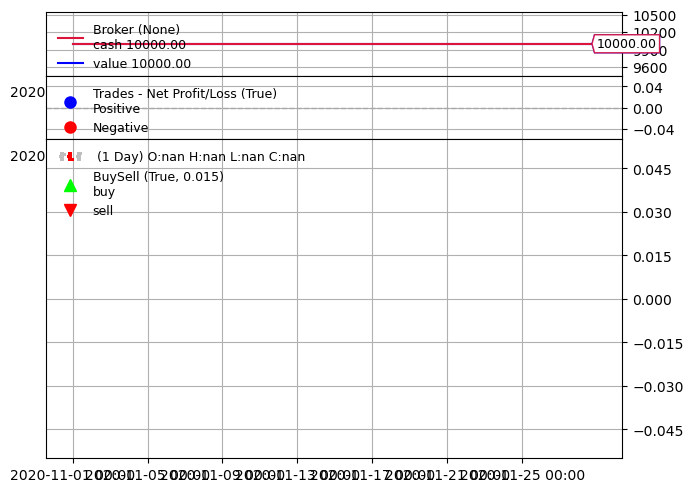

[[<Figure size 640x480 with 3 Axes>]]

In [27]:
cerebro = bt.Cerebro()
data = PandasData(dataname=test_data)
cerebro.adddata(data)
# cerebro.addstrategy(St)
cerebro.run()

# Plot the result
# cerebro.plot(style='bar')
cerebro.plot(volume=False,iplot=False)

In [20]:
cerebro.plot(volume=False)

<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 3 Axes>]]

#### Returns for 1 series and Hurst exponent

In [6]:
# open pickle file and read which ticker from which start - end date
def df_select(path: str, ticker: str, start_date: str, data_point_num: int) -> pd.DataFrame:
    data = pd.read_pickle(path)
    data = data.loc[data['ticker'] == ticker]
    data = data.reset_index(drop=True)
    data['ret'] = data['price_close'].pct_change()
    data.iloc[:, :4] = data.iloc[:, :4].apply(pd.to_datetime, utc=True, errors='coerce')
    data = data.loc[data['time_period_start'] >= start_date]
    if data_point_num is not None:
        data = data.head(data_point_num)
    return data[['time_period_start', 'price_close', 'ret']]

In [10]:
ethusdt = df_select(
    path='overall.pkl',
    ticker='BINANCE_SPOT_MATIC_USDT',
    start_date='2020-11-01',
    data_point_num=int(672)
)

In [8]:
# df -> dataframe with returns
# len_of_df -> 1,2,6,12 months
# ranges -> [1,2,4,8,16,32]
# function for rescaled range 

def rescaled_range(df, ranges):
    # create list of dfs
    # pull all dfs into 1 list
    list_of_dfs = []

    # loop through each range and split accordingly
    for r in ranges:
        range_dfs = np.array_split(df, r)
        for dataframe in range_dfs:
            list_of_dfs.append(dataframe)
    
    # get the mean deviation (Xi - m) 
    for df in list_of_dfs:
        df['mean_deviation'] = df['ret'] - df['ret'].mean()
        
    # populate another dataframe with its values
    hurst_attributes = pd.DataFrame()
    # find the mean
    hurst_attributes['mean'] = [df['ret'].mean() for df in list_of_dfs]
    hurst_attributes['sum_mean_deviation'] = [sum(df['mean_deviation']) for df in list_of_dfs]
    hurst_attributes['max_difference']  = [df['mean_deviation'].max() - df['mean_deviation'].min() for df in list_of_dfs]
    hurst_attributes['stdev']  = [df['ret'].std() for df in list_of_dfs]
    hurst_attributes['rescaled_range'] = hurst_attributes['max_difference']/hurst_attributes['stdev']
    
    # set the ranges
    hurst_attributes['range'] = np.nan
    hurst_attributes.iloc[31:, -1:] = int(32)
    hurst_attributes.iloc[15:31, -1:] = int(16)
    hurst_attributes.iloc[7:15, -1:] = int(8)
    hurst_attributes.iloc[3:7, -1:] = int(4)
    hurst_attributes.iloc[1:3, -1:] = int(2)
    hurst_attributes.iloc[0:1, -1:] = int(1)
    
    # another new dataframe with the average rescaled range for list of rance
    avg_rescaled_range = [hurst_attributes.loc[hurst_attributes['range'] == range_value, 'rescaled_range'].mean() for range_value in hurst_attributes.range.unique()]
    range_size = list(dict.fromkeys([len(df) for df in list_of_dfs]))
    hurst_plot_df = pd.DataFrame(zip(avg_rescaled_range, range_size), columns=['rescaled_range_mean', 'size']).apply(np.log)
    
    return hurst_attributes, hurst_plot_df

In [12]:
test = rescaled_range(ethusdt, ranges=[1,2,4,8,16,32])
test[1]

,rescaled_range_mean,size
0,2.327748,6.510258
1,2.257286,5.817111
2,2.082313,5.123964
3,1.843894,4.430817
4,1.651434,3.737670
5,1.436006,3.044522


In [13]:
# plotting function
def hurst_plot(df):
    # get coeffs of linear fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['size'],df['rescaled_range_mean'])

    # use line_kws to set line label for legend
    ax = sns.regplot(x="size", y="rescaled_range_mean", data=df, color='b', 
    line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})

    # plot legend
    ax.legend()

    plt.show()

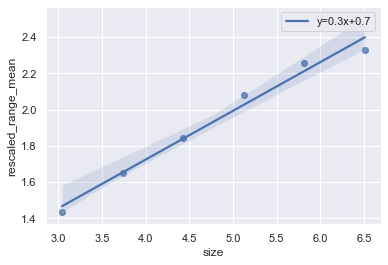

In [14]:
hurst_plot(test[1])

In [57]:
res_btc_usdt = df_select('overall.pkl', 'BINANCE_SPOT_BTC_USDT', '2020-11-01', '2020-12-01')
res_btc_usdt

,time_period_start,price_close,ret
116,2020-11-01 00:00:00+00:00,13725.95,-0.004717
117,2020-11-01 01:00:00+00:00,13759.90,0.002473
118,2020-11-01 02:00:00+00:00,13715.88,-0.003199
119,2020-11-01 03:00:00+00:00,13690.01,-0.001886
120,2020-11-01 04:00:00+00:00,13677.25,-0.000932
...,...,...,...
831,2020-11-30 20:00:00+00:00,19439.48,0.009320
832,2020-11-30 21:00:00+00:00,19381.25,-0.002995
833,2020-11-30 22:00:00+00:00,19499.99,0.006127
834,2020-11-30 23:00:00+00:00,19695.87,0.010045


In [50]:
# using btc_usdt as an example
btc_usdt = df_spot.loc[df_spot['ticker'] == 'BINANCE_SPOT_BTC_USDT']
btc_usdt = btc_usdt[['time_period_start', 'price_close', 'ticker']] 
btc_usdt.reset_index(drop=True, inplace=True)
btc_usdt['time_period_start'] = pd.to_datetime(btc_usdt['time_period_start'], utc=True)

# calculate returns
btc_usdt['ret'] = btc_usdt['price_close'].pct_change() 

# create an extra df from 1st Nov 2020 to start splitting into 63 dfs
res_btc_usdt = btc_usdt[btc_usdt['time_period_start'] >= '2020-11-01']

## One month worth of 1hr data

#### Split array into multiple ranges to get the mean for each series

In [4]:
hurst_one_range = res_btc_usdt.head(672)
ranges = {
    'one range': hurst_one_range,
    'two ranges': np.array_split(hurst_one_range, 2),
    'four ranges': np.array_split(hurst_one_range, 4),
    'eight range': np.array_split(hurst_one_range, 8),
    '16 range': np.array_split(hurst_one_range, 16),
    '32 range': np.array_split(hurst_one_range, 32),
}

In [24]:
hurst_one_range

,time_period_start,price_close,ticker,ret
116,2020-11-01 00:00:00+00:00,13725.95,BINANCE_SPOT_BTC_USDT,-0.004717
117,2020-11-01 01:00:00+00:00,13759.90,BINANCE_SPOT_BTC_USDT,0.002473
118,2020-11-01 02:00:00+00:00,13715.88,BINANCE_SPOT_BTC_USDT,-0.003199
119,2020-11-01 03:00:00+00:00,13690.01,BINANCE_SPOT_BTC_USDT,-0.001886
120,2020-11-01 04:00:00+00:00,13677.25,BINANCE_SPOT_BTC_USDT,-0.000932
...,...,...,...,...
783,2020-11-28 19:00:00+00:00,17814.50,BINANCE_SPOT_BTC_USDT,0.004767
784,2020-11-28 20:00:00+00:00,17673.21,BINANCE_SPOT_BTC_USDT,-0.007931
785,2020-11-28 21:00:00+00:00,17741.05,BINANCE_SPOT_BTC_USDT,0.003839
786,2020-11-28 22:00:00+00:00,17760.03,BINANCE_SPOT_BTC_USDT,0.001070


In [5]:
# every value in ranges dict from 'two ranges' onwards, we find the mean 
list(ranges.values())[1][0]['ret'].mean()

0.0004745478555720082

#### Mean calculation for 63 ranges (on btc_usdt)

In [9]:
# start the list with the one_range df
list_of_means = [list(ranges.values())[0]['ret'].mean()]
start_date = [list(ranges.values())[0].iloc[:, 0:1].values[0][0]]
end_date = [list(ranges.values())[0].iloc[:, 0:1].values[-1][0]]

# number of dfs from 2-32 ranges
range_values = [2, 4, 8, 16, 32]

# loop through each df in dict values to calculate its mean 
for i in range(1, len(ranges)):
    
    # loop through the range_values for each inner df
    for j in range(range_values[i-1]):
        inner_df = list(ranges.values())[i][j]
        mean_value = inner_df['ret'].mean()
        start_dt = inner_df.iloc[:, 0:1].values[0][0]
        end_dt = inner_df.iloc[:, 0:1].values[-1][0]
        
        # store the mean, start_date and end_date
        list_of_means.append(mean_value)
        start_date.append(start_dt)
        end_date.append(end_dt)
        


In [11]:
len(start_date)

63

In [45]:
# create dataframe to store the means, start date and end date range
six_three_means = pd.DataFrame(data=list_of_means, columns=['means for 63 series'])
six_three_means['start_date'] = start_date
six_three_means['end_date'] = end_date

In [48]:
six_three_means.tail()

,means for 63 series,start_date,end_date
58,-0.000238,2020-11-24 15:00:00+00:00,2020-11-25 11:00:00+00:00
59,-0.006248,2020-11-25 12:00:00+00:00,2020-11-26 08:00:00+00:00
60,0.001148,2020-11-26 09:00:00+00:00,2020-11-27 05:00:00+00:00
61,-0.000709,2020-11-27 06:00:00+00:00,2020-11-28 02:00:00+00:00
62,0.002040,2020-11-28 03:00:00+00:00,2020-11-28 23:00:00+00:00


#### For these 63 dataframes find the deviation from its mean

In [51]:
# pull all dfs into 1 list
list_of_dfs = [hurst_one_range]
ranges = [2,4,8,16,32]

# loop through each range and split accordingly
for r in ranges:
    range_dfs = np.array_split(hurst_one_range, r)
    for df in range_dfs:
        list_of_dfs.append(df)

In [ ]:
# df -> dataframe with returns
# len_of_df -> 1,2,6,12 months
# ranges -> [1,2,4,8,16,32]

def rescaled_range(df, len_of_df, ranges):
    # create list of dfs
    # pull all dfs into 1 list
    list_of_dfs = [df]

    # loop through each range and split accordingly
    for r in ranges:
        range_dfs = np.array_split(df, r)
        for dataframe in range_dfs:
            list_of_dfs.append(dataframe)
    
    # get the mean deviation (Xi - m) 
    for df in list_of_dfs:
        df['mean_deviation'] = df['ret'] - df['ret'].mean()
        
    # populate another dataframe with its values
    hurst_attributes = pd.DataFrame()
    # find the mean
    hurst_attributes['mean'] = [df['ret'].mean() for df in list_of_dfs]
    hurst_attributes['sum_mean_deviation'] = [sum(df['mean_deviation']) for df in list_of_dfs]
    hurst_attributes['max_difference']  = [df['mean_deviation'].max() - df['mean_deviation'].min() for df in list_of_dfs]
    hurst_attributes['stdev']  = [df['ret'].std() for df in list_of_dfs]
    hurst_attributes['rescaled_range'] = hurst_attributes['max_difference']/six_three_means['stdev']
    
    # set the ranges
    hurst_attributes['range'] = np.nan
    hurst_attributes.iloc[31:, -1:] = int(32)
    hurst_attributes.iloc[15:31, -1:] = int(16)
    hurst_attributes.iloc[7:15, -1:] = int(8)
    hurst_attributes.iloc[3:7, -1:] = int(4)
    hurst_attributes.iloc[1:3, -1:] = int(2)
    hurst_attributes.iloc[0:1, -1:] = int(1)
    
    # another new dataframe with the average rescaled range for list of rance
    avg_rescaled_range = [hurst_attributes.loc[hurst_attributes['range'] == range_value, 'rescaled_range'].mean() for range_value in hurst_attributes.range.unique()]
    range_size = list(dict.fromkeys([len(df) for df in list_of_dfs]))
    hurst_plot_df = pd.DataFrame(zip(avg_rescaled_range, range_size), columns=['rescaled_range_mean', 'size']).apply(np.log)
    
    return hurst_attributes, hurst_plot_df

In [55]:
# find the mean deviations
means = six_three_means['means for 63 series'].tolist()

for df, mean in zip(list_of_dfs, means):
    df['mean_deviation'] = df['ret'] - mean

d:\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [58]:
# show the mean_deviation for one_range_hurst
list_of_dfs[0]

,time_period_start,price_close,ticker,ret,mean_deviation
116,2020-11-01 00:00:00+00:00,13725.95,BINANCE_SPOT_BTC_USDT,-0.004717,-0.005116
117,2020-11-01 01:00:00+00:00,13759.90,BINANCE_SPOT_BTC_USDT,0.002473,0.002074
118,2020-11-01 02:00:00+00:00,13715.88,BINANCE_SPOT_BTC_USDT,-0.003199,-0.003599
119,2020-11-01 03:00:00+00:00,13690.01,BINANCE_SPOT_BTC_USDT,-0.001886,-0.002286
120,2020-11-01 04:00:00+00:00,13677.25,BINANCE_SPOT_BTC_USDT,-0.000932,-0.001332
...,...,...,...,...,...
783,2020-11-28 19:00:00+00:00,17814.50,BINANCE_SPOT_BTC_USDT,0.004767,0.004367
784,2020-11-28 20:00:00+00:00,17673.21,BINANCE_SPOT_BTC_USDT,-0.007931,-0.008331
785,2020-11-28 21:00:00+00:00,17741.05,BINANCE_SPOT_BTC_USDT,0.003839,0.003439
786,2020-11-28 22:00:00+00:00,17760.03,BINANCE_SPOT_BTC_USDT,0.001070,0.000670


#### Sum of mean deviations for each dataframe

In [112]:
# create the running total of mean_deviation in each df (63)
mean_deviation_sums = [sum(df['mean_deviation']) for df in list_of_dfs]
max_difference_each_range = [df['mean_deviation'].max() - df['mean_deviation'].min() for df in list_of_dfs]
stdev = [df['ret'].std() for df in list_of_dfs]

# set new df columns
six_three_means['mean_deviation_sums'] = mean_deviation_sums
six_three_means['max_difference'] = max_difference_each_range
six_three_means['stdev'] = stdev
six_three_means['rescaled_range'] = six_three_means['max_difference']/six_three_means['stdev']


In [113]:
six_three_means

,means for 63 series,start_date,end_date,mean_deviation_sums,max_difference,stdev,rescaled_range,range
0,0.000399,2020-11-01 00:00:00+00:00,2020-11-28 23:00:00+00:00,7.164408e-16,0.079565,0.007264,10.954078,1.0
1,0.000475,2020-11-01 00:00:00+00:00,2020-11-14 23:00:00+00:00,1.032160e-16,0.043182,0.006202,6.962325,2.0
2,0.000324,2020-11-15 00:00:00+00:00,2020-11-28 23:00:00+00:00,-7.424616e-16,0.079565,0.008197,9.706274,2.0
3,0.000450,2020-11-01 00:00:00+00:00,2020-11-07 23:00:00+00:00,-2.673643e-16,0.041628,0.006718,6.196716,4.0
4,0.000499,2020-11-08 00:00:00+00:00,2020-11-14 23:00:00+00:00,-8.673617e-19,0.040180,0.005660,7.098915,4.0
...,...,...,...,...,...,...,...,...
58,-0.000238,2020-11-24 15:00:00+00:00,2020-11-25 11:00:00+00:00,3.767603e-18,0.019206,0.005608,3.424602,32.0
59,-0.006248,2020-11-25 12:00:00+00:00,2020-11-26 08:00:00+00:00,-2.081668e-17,0.050998,0.012020,4.242866,32.0
60,0.001148,2020-11-26 09:00:00+00:00,2020-11-27 05:00:00+00:00,-1.734723e-18,0.056399,0.013615,4.142577,32.0
61,-0.000709,2020-11-27 06:00:00+00:00,2020-11-28 02:00:00+00:00,0.000000e+00,0.034939,0.010740,3.253154,32.0


In [79]:
# creating rows to indicate which range
six_three_means['range'] = np.nan
six_three_means.iloc[31:, -1:] = int(32)
six_three_means.iloc[15:31, -1:] = int(16)
six_three_means.iloc[7:15, -1:] = int(8)
six_three_means.iloc[3:7, -1:] = int(4)
six_three_means.iloc[1:3, -1:] = int(2)
six_three_means.iloc[0:1, -1:] = int(1)

In [114]:
# average rescaled range for each means
avg_rescaled_range = [six_three_means.loc[six_three_means['range'] == range_value, 'rescaled_range'].mean() for range_value in six_three_means.range.unique()]
df_length = list(dict.fromkeys([len(df) for df in list_of_dfs]))
hurst_df = pd.DataFrame(zip(avg_rescaled_range, df_length), columns=['rescaled_range_mean', 'size'])

In [116]:
# log the values
hurst_df = hurst_df.apply(np.log) 

In [117]:
hurst_df

,rescaled_range_mean,size
0,2.393712,6.510258
1,2.120380,5.817111
2,2.043123,5.123964
3,1.836456,4.430817
4,1.598866,3.737670
5,1.371393,3.044522


#### Visualising hurst plot

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set_theme()

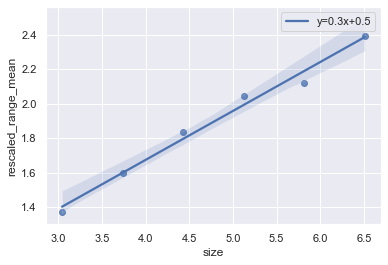

In [135]:
# get coeffs of linear fit
slope, intercept, r_value, p_value, std_err = stats.linregress(hurst_df['size'],hurst_df['rescaled_range_mean'])

# use line_kws to set line label for legend
ax = sns.regplot(x="size", y="rescaled_range_mean", data=hurst_df, color='b', 
 line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})

# plot legend
ax.legend()

plt.show()

Hurst exponent = 0.3 for the Nov-2020 for btc_usdt
- likely to reverse trend over time?